# Building a Challenge Classifier Using Transfer Learning
Trying to identify clips of challengess from Bundesliga games. This transfer learning model will be built with fastai and this notebook will build and train that model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from tqdm.notebook import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_path = Path('data/')
train_df = pd.read_csv(data_path/'train.csv')
train_df.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


In [3]:
df_challenge = train_df[train_df['event'] == 'challenge'].copy()
df_challenge.head()

,video_id,time,event,event_attributes
1,1606b0e6_0,201.15,challenge,['ball_action_forced']
4,1606b0e6_0,210.87,challenge,['opponent_dispossessed']
59,1606b0e6_0,300.99,challenge,['possession_retained']
62,1606b0e6_0,307.27,challenge,['opponent_dispossessed']
79,1606b0e6_0,395.55,challenge,['ball_action_forced']


In [4]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"train_{row.name}.mp4"
    ffmpeg_extract_subclip(
        f'data/train/{row["video_id"]}.mp4',
        #f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        row['time'] - before, 
        row['time'] + after, 
        targetname=filename
    )
    
    return Video(filename, width=800)

In [5]:
r = df_challenge.iloc[5]
vis_event(r,1,1)

['opponent_dispossessed']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [6]:
fps = 25
def get_images(vid_id, time, ind, time_diff, replace=False):
    t1 = time - time_diff
    t2 = time + time_diff
    frame_start = int(t1 * fps)
    frame_end = int(t2 * fps)

    video_file = data_path/'train'/vid_id
    p = data_path/vid_id/f'{ind}'
    if not os.path.exists(p):
        os.makedirs(p)
    for j in range(frame_start, frame_end + 1):
        if not os.path.exists(p/f'{j}.png') or replace == True:
            try:
                image = iio.imread(f'{video_file}.mp4', index=j)
                iio.imwrite(p/f'{j}.png', image)
            except IndexError:
                print(j, p)
                p = None
    return p

In [7]:
fnames = [get_images(v, t, i, 0.3) for v, t, i in tqdm(zip(df_challenge['video_id'], df_challenge['time'], df_challenge.index.values), total=len(df_challenge))]
df_challenge['fnames'] = fnames
print(len(fnames))
fnames[0:3]

  0%|          | 0/624 [00:00<?, ?it/s]

624


[Path('data/1606b0e6_0/1'),
 Path('data/1606b0e6_0/4'),
 Path('data/1606b0e6_0/59')]

In [8]:
# making a negative dataset the size of the positive one
scale = 1

pos_set = df_challenge['time'].astype(int)
neg_set = []
while len(neg_set) < len(df_challenge) * scale:
    tmp = random.randint(0,(12*60)-1)
    if tmp not in neg_set and tmp not in pos_set:
        neg_set.append(tmp)

neg_paths = []
for a in data_path.ls():
    if '.' not in str(a):
        for b in a.ls():
            if '-' in str(b):
                neg_paths.append(b)
count = len(neg_paths)
if len(neg_paths) < len(neg_set):
    vid_paths = data_path/'train'
    vid_paths = vid_paths.ls()
    index = -1*len(neg_set)
    for t in tqdm(neg_set):
        i = random.randint(0,len(vid_paths)-1)
        neg_paths.append(get_images(vid_paths[i].stem, t, index, 0.3))
        index += -1
        count += 1
        if count == len(neg_set):
            break


In [9]:
print(len(neg_paths))
neg_paths[:3]

994


[Path('data/1606b0e6_0/-102'),
 Path('data/1606b0e6_0/-112'),
 Path('data/1606b0e6_0/-137')]

In [10]:
df_train = pd.DataFrame(df_challenge.fnames.copy())
df_train['label'] = ['challenge'] * len(df_challenge)
len(df_train)
df_neg = pd.DataFrame({'fnames': neg_paths, 'label': ['no_challenge'] * len(neg_paths)})
df_train = pd.concat([df_train, df_neg])

In [11]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [12]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [13]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [14]:
def labeller(path):
    return '-' not in str(path)

In [15]:
instances_path = df_train.fnames.copy()
splits = RandomSplitter()(instances_path)

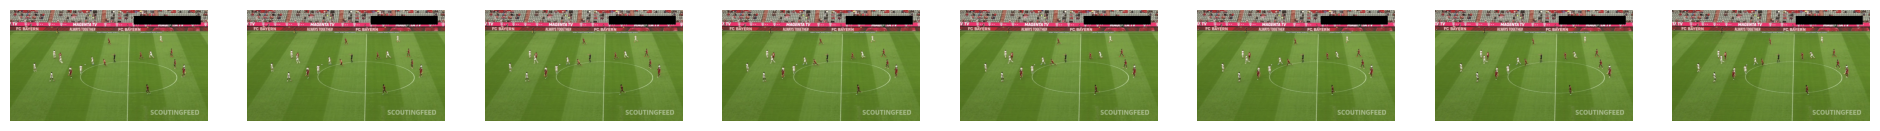

In [16]:
frames = instances_path[0].ls_sorted()
show_images([Image.open(img) for img in frames])

In [17]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [labeller, Categorize()]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


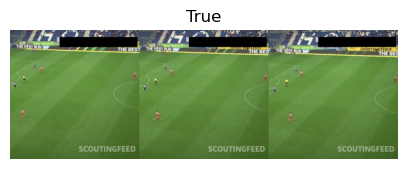

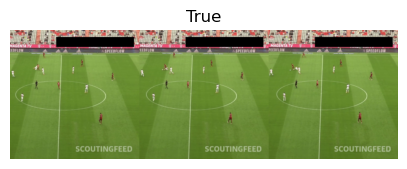

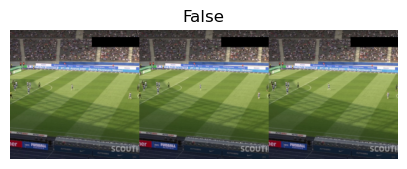

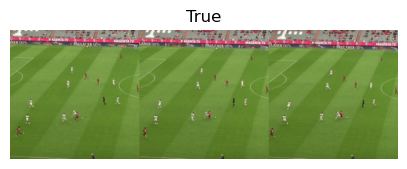

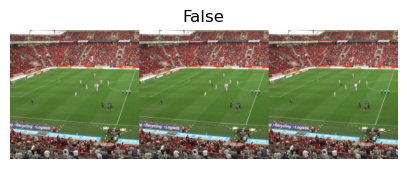

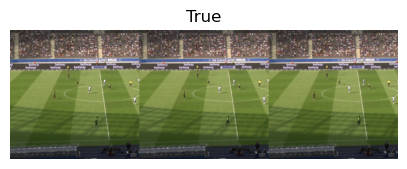

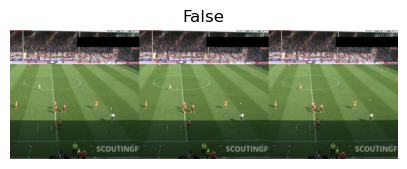

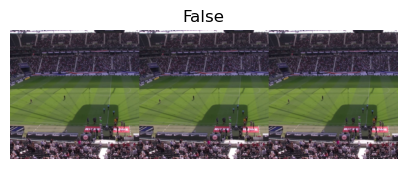

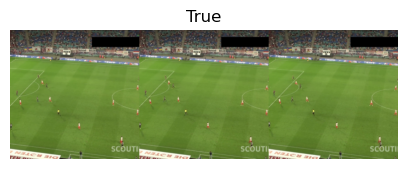

In [18]:
dls = get_action_dataloaders(instances_path, bs=16, image_size=256, seq_len=8) #todo: change to 10??
dls.show_batch()

In [19]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [20]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [21]:
model = RNNModel().cuda()

In [22]:
learn = Learner(dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(valley=0.0012022644514217973)

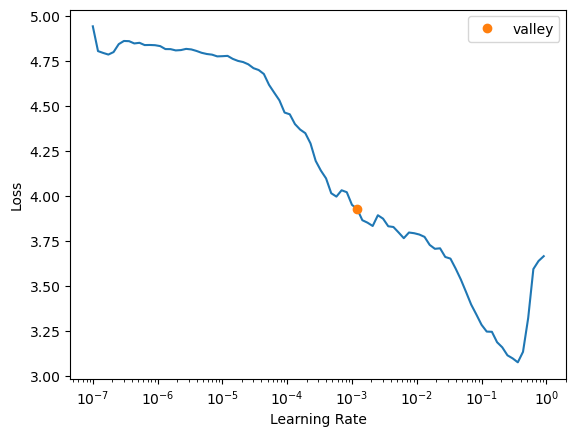

In [24]:
learn.lr_find()

In [23]:
learn.fine_tune(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,3.734974,3.100042,0.520124,0.479876,17:35


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,2.770656,3.820755,0.436532,0.563467,14:51
1,2.407218,3.879008,0.436532,0.563467,14:46
2,1.797056,2.838640,0.371517,0.628483,14:48
3,1.011598,0.850082,0.281734,0.718266,14:48
4,0.649495,1.459918,0.486068,0.513932,14:50
5,0.540678,0.974713,0.312694,0.687307,14:47
6,0.473272,0.571016,0.284830,0.715170,14:48
7,0.426571,0.486545,0.250774,0.749226,15:08
8,0.414071,0.503139,0.275542,0.724458,14:49
9,0.411679,0.488772,0.241486,0.758514,14:48


In [24]:
learn.save('challenge_256_v2')
learn.export('challenge_256_v2.pkl')

Best params so far:
- 8 frames
- Image size: 256
- Epochs trained: 10
- Batch Size: 16
- Error Rate/F1: 8%/0.92
- filename: challenge_256_92.pth

In [23]:
learn.load('challenge_256_92')
learn.export('challenge_256.pkl')